<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Code-Along

_Authors: Joseph Nelson (DC)_

---

### Learning Objectives
- Conduct a Dickey-Fuller test for stationarity and plot the results.
- Perform first and second order differencing, as well as seasonal differencing on data.
- Plot ACF and PACF with European retail data.
- Examine the use of SARIMAX state-space modeling for advanced time series forecasting.

### Lesson Guide
- [Statsmodels' Time Series Tools](#statsmodels-timeseries-tools)
- [Bus Ridership Data](#bus-ridership-data)
	- [Clean the Data](#clean-the-data)
	- [Create a Date Index for the Data](#create-a-date-index-for-the-data)
- [Plot the Riders Across Months](#plot-the-riders-across-months)
- [Decompose the Time Series and Plot](#decompose-the-timeseries-and-plot)
- [Dickey-Fuller Test of Stationarity](#dickey-fuller-test-of-stationarity)
	- [Perform a Test on the First-Differenced Time Series](#perform-test-on-the-first-differenced-timeseries)
	- [Perform a Test on *Seasonal*-Differenced Time Series](#perform-test-on-seasonal-differenced-timeseries)
	- [Perform a Test on the First Seasonal-Differenced Time Series](#perform-a-test-on-the-first-seasonal-differenced-timeseries)
- [Load the European Retail Data](#load-the-european-retail-data)
- [Create Autocorrelation and Partial Autocorrelation Plots](#create-autocorrelation-and-partial-autocorrelation-plots)
	- [Take a Second-Order Difference of the Retail Time Series](#take-a-second-order-difference-of-the-retail-timeseries)
- [Seasonal ARIMA With Additional Predictors (SARIMAX)](#seasonal-arima-with-additional-predictors-sarimax)
	- [Forecast Using the SARIMAX Model](#forecast-using-the-sarimax-model)
- [Additional Resources](#additional-resources)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn as sns

<a id="statsmodels-timeseries-tools"></a>
## Statsmodels' Time Series Tools
---

Statsmodels, offers a wide variety of reliable time series analysis tools. We will start off by loading the autocorrelation and partial autocorrelation functions, as well as a function for decomposing time series.

In [2]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/allenstedman/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id="bus-ridership-data"></a>
## Bus Ridership Data
---

We are going to play around with some Portland, Oregon, bus data. Load in the bus data below and check it out.

<a id="clean-the-data"></a>
### Clean the Data

In [97]:
# Data: https://datamarket.com/data/set/22w6/portland-oregon-average-monthly-bus-ridership-100-january-1973-through-june-1982-n114#!ds=22w6&display=line
bus = pd.read_csv('./datasets/portland-oregon-average-monthly-.csv')
bus.head()

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [98]:
bus.tail()

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
111,1969-04,1432
112,1969-05,1394
113,1969-06,1327
114,NaN,NaN
115,Portland Oregon average monthly bus ridership ...,n=114


There are a couple of bad rows. Get rid of them.

In [99]:
# A:
bus.drop([114,115], inplace=True)

In [100]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 113
Data columns (total 2 columns):
Month                                                                                         114 non-null object
Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114    114 non-null object
dtypes: object(2)
memory usage: 2.7+ KB


Make the `riders` column an integer.

In [101]:
# A:
bus.columns = ['date', 'riders']
bus.head()

,date,riders
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [7]:
bus.riders = bus.riders.apply(lambda x: int(x))
bus.riders = bus.riders.astype(int)
bus.riders.head()

0    648
1    646
2    639
3    654
4    630
Name: riders, dtype: int64

<a id="create-a-date-index-for-the-data"></a>
### Create a Date Index for the Data

We are going to create an artificial date index using the `relativedelta()` function, as exemplified below. We will simply start at `1973-01-01` and iterate up a month at a time.

In [8]:
type(bus['date'][0])

str

In [10]:
# A:
bus['date'] = pd.to_datetime(bus.date)
bus['date'][0]

Timestamp('1960-01-01 00:00:00')

In [11]:
dt = datetime(1973, 1, 1) - datetime(1960, 1, 1) ## Find off set from
##where where want to be
bus.date = bus.date + dt ## Add offset to existing data

In [12]:
bus.set_index('date', inplace=True)

In [13]:
bus.head()

,riders
date,
1973-01-01,648
1973-02-01,646
1973-03-02,639
1973-04-02,654
1973-05-02,630


In [15]:
bus.index.day.unique() ## make sure that all the days are the beginning
## of the month

Int64Index([1, 2], dtype='int64', name='date')

<a id="plot-the-riders-across-months"></a>
## Plot the Riders Across Months
---

We can look at the raw ridership data first.

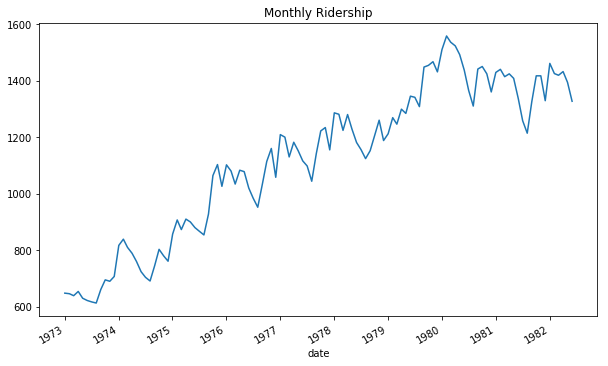

In [16]:
# A:
bus.riders.plot(figsize=(10,6), title='Monthly Ridership')

<a id="decompose-the-timeseries-and-plot"></a>
## Decompose the Time Series and Plot
---

Using the `seasonal_decompose()` function, we can break the time series into its constituent parts.

Use the function on the `riders` data with a frequency of 12, then plot the data.

> **Hint:** The decomposition object from `seasonal_decompose()` has a `.plot()` function, like with Pandas DataFrames.

In [17]:
bus.index = pd.date_range('1/1/1973', periods=len(bus.index), freq='M')

In [18]:
bus.index

DatetimeIndex(['1973-01-31', '1973-02-28', '1973-03-31', '1973-04-30',
               '1973-05-31', '1973-06-30', '1973-07-31', '1973-08-31',
               '1973-09-30', '1973-10-31',
               ...
               '1981-09-30', '1981-10-31', '1981-11-30', '1981-12-31',
               '1982-01-31', '1982-02-28', '1982-03-31', '1982-04-30',
               '1982-05-31', '1982-06-30'],
              dtype='datetime64[ns]', length=114, freq='M')

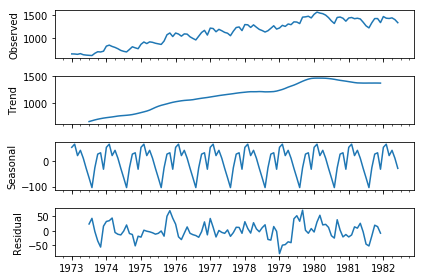

In [19]:
# A:
decomposition = seasonal_decompose(bus.riders, freq=12)
## freq = 12 tells it to look around 12 unit increments
decomposition.plot();

**Plot just the seasonal component.**

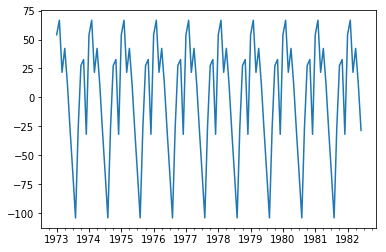

In [20]:
# A:
seasonal = decomposition.seasonal
seasonal.plot()

In [21]:
seasonal[:13] ## See the seasonalitly

1973-01-31     54.110147
1973-02-28     66.641397
1973-03-31     21.672647
1973-04-30     42.323688
1973-05-31     11.276813
1973-06-30    -28.499228
1973-07-31    -65.588349
1973-08-31   -104.069830
1973-09-30    -26.176312
1973-10-31     27.499614
1973-11-30     32.694059
1973-12-31    -31.884645
1974-01-31     54.110147
Freq: M, Name: riders, dtype: float64

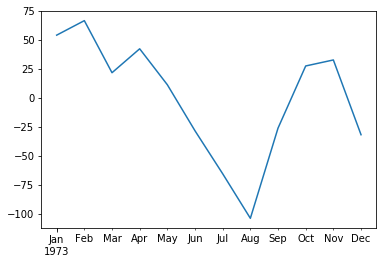

In [22]:
seasonal = decomposition.seasonal
seasonal[:12].plot()

<a id="dickey-fuller-test-of-stationarity"></a>
## Dickey-Fuller Test of Stationarity
---

[We can perform an (augmented) Dickey-Fuller test of stationarity](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to evaluate whether or not the time series is stationary.


In [23]:
# A:
# Define a Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )

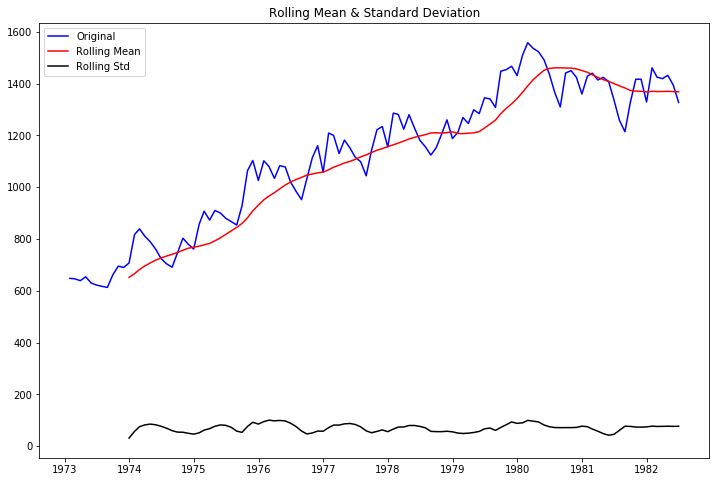

Results of Dickey-Fuller Test:
Test Statistic   -1.536597
p-value           0.515336
dtype: float64


In [24]:
# Perform test.
test_stationarity(bus.riders)

In [26]:
decomposition.resid.head()

1973-01-31   NaN
1973-02-28   NaN
1973-03-31   NaN
1973-04-30   NaN
1973-05-31   NaN
Freq: M, Name: riders, dtype: float64

In [28]:
decomposition.resid[6:-6]  ## selecting data without NaNs from above

1973-07-31    23.713349
1973-08-31    43.111497
1973-09-30    -1.948688
1973-10-31   -34.374614
1973-11-30   -55.610725
1973-12-31    16.301312
1974-01-31    32.431520
1974-02-28    35.025270
1974-03-31    44.244020
1974-04-30    -5.407022
1974-05-31   -11.610147
1974-06-30   -13.834105
1974-07-31    -0.661651
1974-08-31    20.319830
1974-09-30    -9.032022
1974-10-31   -12.374614
1974-11-30   -51.444059
1974-12-31   -18.198688
1975-01-31   -21.485147
1975-02-28     2.400270
1975-03-31    -1.047647
1975-04-30    -3.198688
1975-05-31    -6.485147
1975-06-30   -11.209105
1975-07-31    -8.369985
1975-08-31    -0.305170
1975-09-30   -18.115355
1975-10-31    50.292052
1975-11-30    69.472608
1975-12-31    43.801312
                ...    
1979-07-31    52.171682
1979-08-31    33.194830
1979-09-30    71.176312
1979-10-31     2.083719
1979-11-30    -8.110725
1979-12-31     7.967978
1980-01-31    -3.860147
1980-02-29    30.525270
1980-03-31    53.702353
1980-04-30    20.509645
1980-05-31    22

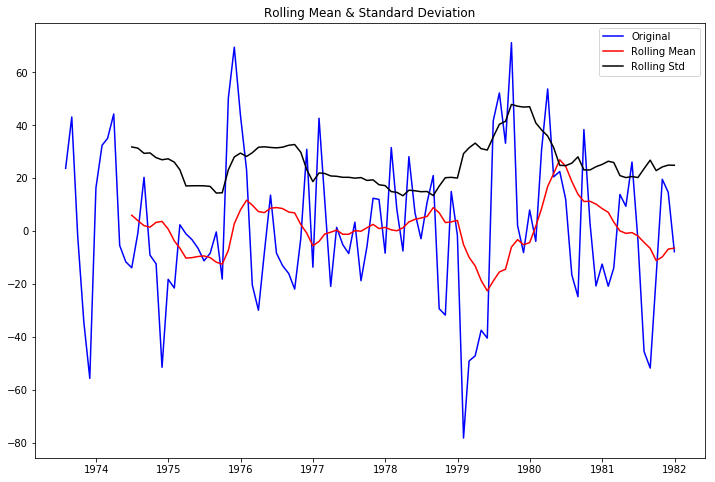

Results of Dickey-Fuller Test:
Test Statistic   -5.731921e+00
p-value           6.570180e-07
dtype: float64


In [30]:
test_stationarity(decomposition.resid[6:-6])

<a id="perform-test-on-the-first-differenced-timeseries"></a>
### Perform a Test on the First-Differenced Time Series

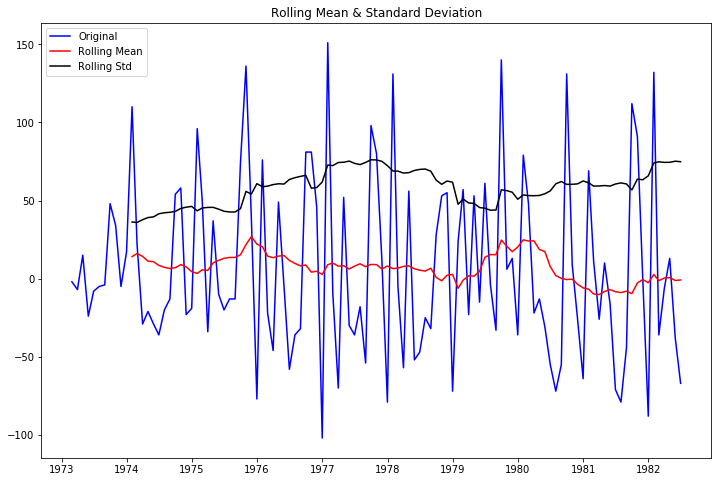

Results of Dickey-Fuller Test:
Test Statistic   -1.938696
p-value           0.314082
dtype: float64


In [31]:
# A:
bus['first_difference'] = bus.riders.diff()
test_stationarity(bus.first_difference.dropna())

#### Dicky fuller test says that this is not stationary, P value over .05


<a id="perform-test-on-seasonal-differenced-timeseries"></a>
### Perform a Test on *Seasonal*-Differenced Time Series

Where the season will be a year's difference (12 months).

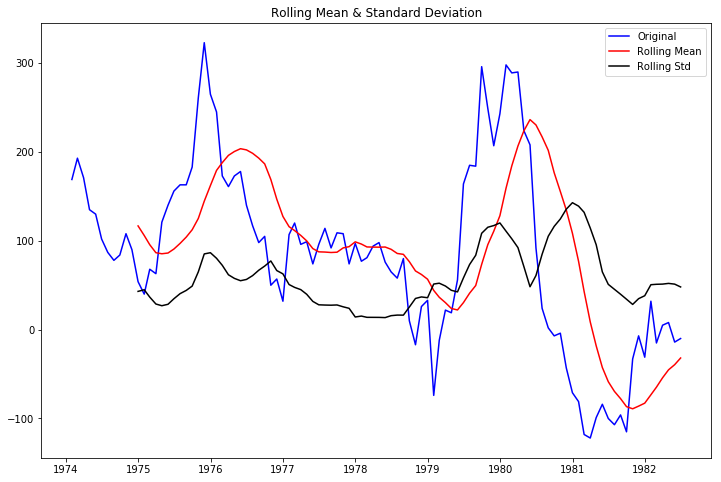

Results of Dickey-Fuller Test:
Test Statistic   -2.469741
p-value           0.123011
dtype: float64


In [34]:
# A:
# diff() ----  delta_y = y_t - y_{t-1}
# diff(12) --- delta_y = y_t - y_{t-12}
bus['seasonal_difference'] = bus.riders.diff(12)
test_stationarity(bus.seasonal_difference.dropna())

#### Dicky fuller test says that this is not stationary, P value over .05

<a id="perform-a-test-on-the-first-seasonal-differenced-timeseries"></a>
### Perform a Test on the First Seasonal-Differenced Time Series

At this point, we can see that we have a significant result!

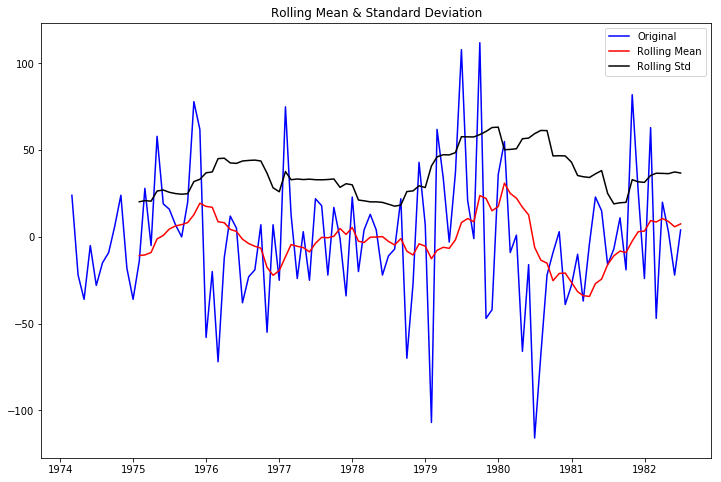

Results of Dickey-Fuller Test:
Test Statistic   -9.258520e+00
p-value           1.427874e-15
dtype: float64


In [36]:
# A:
bus['seasonal_first_difference'] = bus.riders.diff(1).diff(12)
test_stationarity(bus.seasonal_first_difference.dropna())

#### Taking two derivatives has made the data stationary, P < .05

In [38]:
train_test = bus.dropna()

In [39]:
train_test.shape

(101, 4)

In [40]:
train_test.head()

,riders,first_difference,seasonal_difference,seasonal_first_difference
1974-02-28,839,22.0,193.0,24.0
1974-03-31,810,-29.0,171.0,-22.0
1974-04-30,789,-21.0,135.0,-36.0
1974-05-31,760,-29.0,130.0,-5.0
1974-06-30,724,-36.0,102.0,-28.0


In [48]:
from statsmodels.tsa.arima_model import ARMA

train = train_test.head(80)
test = train_test.tail(21)
## This is not the same as cross_val_score, which doesnt make sense due
# to the time based relationship of rows.

model = ARMA(train.seasonal_first_difference, (3,1)).fit()
model.summary()


/Users/allenstedman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/allenstedman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                 
=====================================================================================
Dep. Variable:     seasonal_first_difference   No. Observations:                   80
Model:                            ARMA(3, 1)   Log Likelihood                -407.417
Method:                              css-mle   S.D. of innovations             39.374
Date:                       Tue, 26 Jun 2018   AIC                            826.834
Time:                               14:48:37   BIC                            841.126
Sample:                           02-28-1974   HQIC                           832.564
                                - 09-30-1980                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.5747      5.870     -0.439      0.662     -14.079       8.929
ar.L1.seasonal_first_difference     0.2395      0.421      0.569      0.571      -0.586       1.065
ar.L2.seasonal_first_difference    -0.0694      0.121     -0.575      0.567      -0.306       0.167
ar.L3.seasonal_first_difference     0.1767      0.112      1.574      0.120      -0.043       0.397
ma.L1.seasonal_first_difference    -0.1235      0.420     -0.294      0.769      -0.946       0.699
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6500           -0.0000j            1.6500           -0.0000
AR.2           -0.6286           -1.7421j            1.8520           -0.3051
AR.3           -0.6286           +1.7421j            1.8520            0.3051
MA.1            8.0940           +0.0000j            8.0940            0.0000
-----------------------------------------------------------------------------
"""

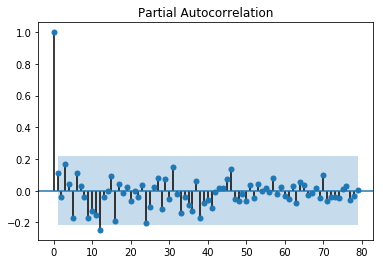

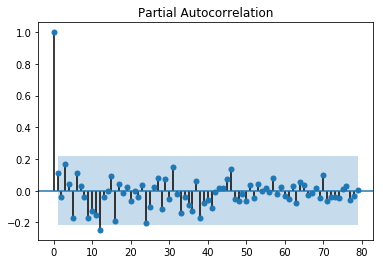

In [49]:
plot_pacf(train.seasonal_first_difference)

In [50]:
# Method 1
# based on indices of training date
start = len(train) - 1
end = start + len(test) - 1  # this is past end of training data

# Method 2
# based on dates of training data
start = test.index[0]
end = test.index[-1]

predictions_oos = model.predict(start=start, end=end)
truth = test.seasonal_first_difference

/Users/allenstedman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [102]:
test.index[-1]

Timestamp('1982-06-30 00:00:00', freq='M')

In [51]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(truth, predictions_oos)

23.907610032419175

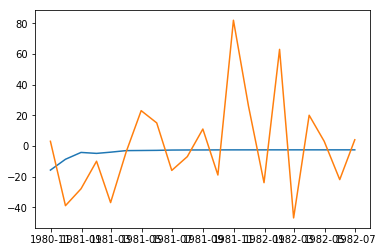

In [52]:
plt.plot(truth.index, predictions_oos, label='Predictions')
plt.plot(truth.index, truth.values, label='Truth')

/Users/allenstedman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/allenstedman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/allenstedman/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


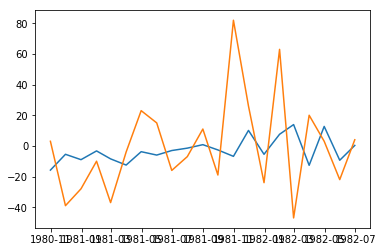

In [57]:
## ROLLING PREDICTIONS

predictions_rolling = []
training_observations = list(train.seasonal_first_difference.values)
testing_observations = test.seasonal_first_difference.values

for obs in testing_observations:
    model_rolling = ARMA(training_observations, (3,1)).fit()
    predictions_rolling.append(model_rolling.forecast()[0][0])
    training_observations.append(obs)

plt.plot(test.index, predictions_rolling, label = 'Training')
plt.plot(test.index, testing_observations, label = 'Truth')

# predictions_rolling = []
# training_observations = list(train.seasonal_first_difference.values)
# testing_observations = test.seasonal_first_difference.values

# for obs in testing_observations:
#     model_rolling = ARMA(training_observations, (3,1)).fit()
#     predictions_rolling.append(model_rolling.forecast()[0][0])
#     training_observations.append(obs)

# plt.plot(test.index, predictions_rolling, label='Fitted')
# plt.plot(test.index, testing_observations, label='Truth')

In [58]:
mean_absolute_error(predictions_rolling, testing_observations)

24.10384969338293

<a id="load-the-european-retail-data"></a>
## Load the European Retail Data
---

Make the index the year and create an initial plot of the data.

In [68]:
df = pd.read_csv('./datasets/euretail.csv')
df = df.set_index(['Year'])
df = df.stack()
df.index = pd.date_range('1/1/1997', freq='Q', periods=len(df.index))

In [70]:
df.head()

1997-03-31    89.13
1997-06-30    89.52
1997-09-30    89.88
1997-12-31    90.12
1998-03-31    89.19
Freq: Q-DEC, dtype: float64

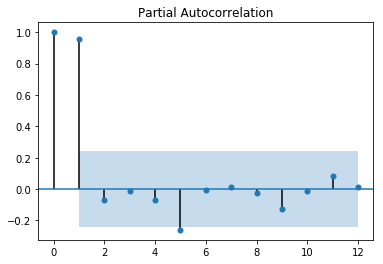

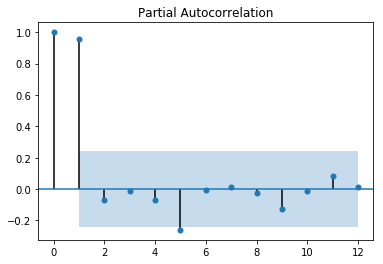

In [75]:
plot_pacf(df, lags = 12)

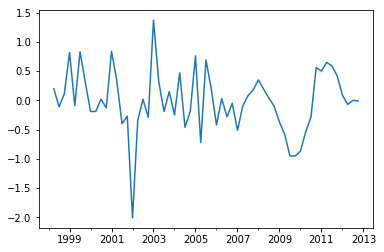

In [76]:
diff0 = df.diff(periods=4)[4:]
diff1 = diff0.diff().dropna()  # 4Q diff and a 1Q diff
diff1.plot()

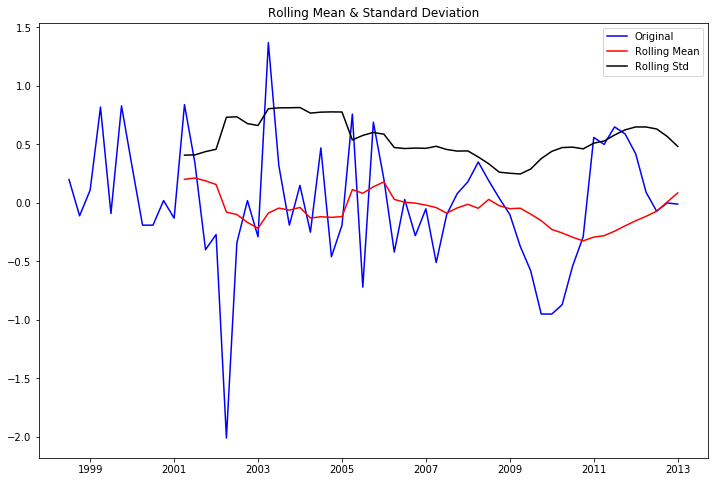

Results of Dickey-Fuller Test:
Test Statistic   -3.559370
p-value           0.006587
dtype: float64


In [77]:
test_stationarity(diff1)

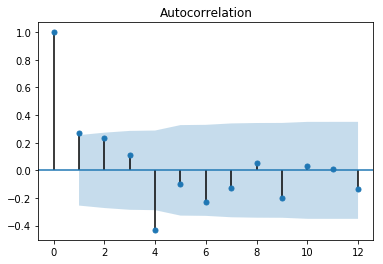

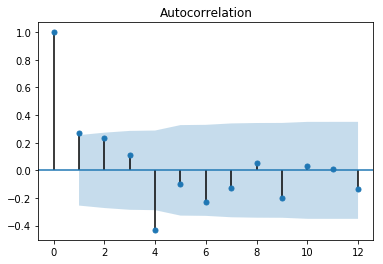

In [79]:
plot_acf(diff1, lags = 12)

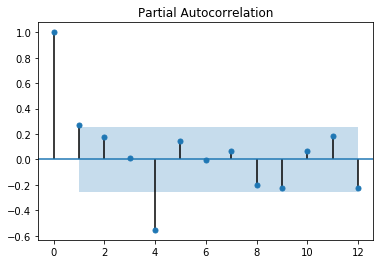

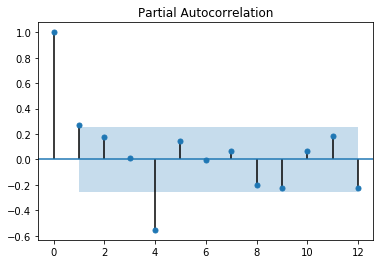

In [80]:
plot_pacf(diff1, lags = 12)

<a id="create-autocorrelation-and-partial-autocorrelation-plots"></a>
## Create Autocorrelation and Partial Autocorrelation Plots 
---

Create a first-differenced time series of the retail data, then use `plot_acf` and `plot_pacf`.

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

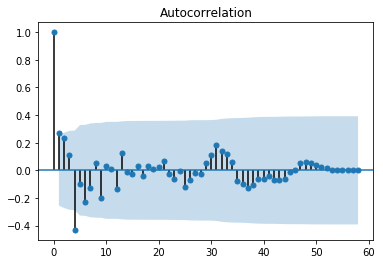

In [83]:
# A:
plot_acf(diff1);

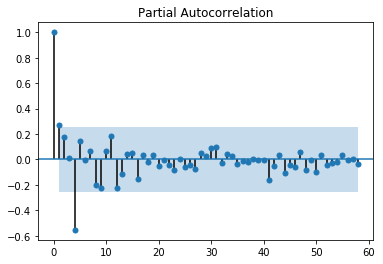

In [85]:
plot_pacf(diff1);

<a id="take-a-second-order-difference-of-the-retail-timeseries"></a>
### Take a Second-Order Difference of the Retail Time Series

Plot the ACF and PACF again with the second-order differenced series.

In [ ]:
# A:

<a id="seasonal-arima-with-additional-predictors-sarimax"></a>
## Seasonal ARIMA With Additional Predictors (SARIMAX)
---

The [SARIMAX model](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) is an advanced state-space model that allows us to build a seasonal ARIMA and also take into account the effects of other predictors.

The granular details of SARIMAX are beyond the scope of this walk-through, but we can build a model and use it to forecast as an example of Statsmodels' powerful time series analysis capabilities.

In [81]:
df.head()

1997-03-31    89.13
1997-06-30    89.52
1997-09-30    89.88
1997-12-31    90.12
1998-03-31    89.19
Freq: Q-DEC, dtype: float64

In [82]:
# AR(1), SAR(1)
# y_t = c + beta_1 * y_{t-1} + beta_{s,1} * y_{t-S}

df = pd.read_csv('./datasets/euretail.csv')
df = df.set_index(['Year'])
df = df.stack()

import statsmodels.api as sm

p = 0  # quarterly model
d = 1  # num of differences to take (.dif(1))
q = 1  # num of MA terms

P = 0  # seasonal model
D = 1  # num of differences (.diff(4))
Q = 1  # num of MA terms

s = 4  # 4 quarters per "Season"

model = sm.tsa.statespace.SARIMAX(df.values, 
                                  order=(p,d,q), 
                                  seasonal_order=(P,D,Q,s))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -34.680
Date:                           Tue, 26 Jun 2018   AIC                             75.360
Time:                                   15:29:07   BIC                             81.837
Sample:                                        0   HQIC                            77.912
                                            - 64                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2901      0.155      1.869      0.062      -0.014       0.594
ma.S.L4       -0.6909      0.132     -5.241      0.000      -0.949      -0.432
sigma2         0.1812      0.034      5.307      0.000       0.114       0.248
===================================================================================
Ljung-Box (Q):                       33.87   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.74   Prob(JB):                         0.39
Heteroskedasticity (H):               0.76   Skew:                            -0.22
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Plot the residuals of the SARIMAX model.**

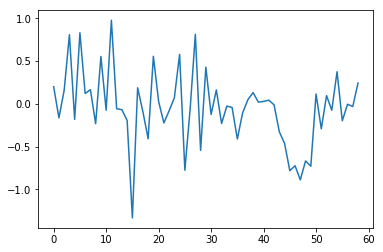

In [88]:
# A:
residuals = results.resid[5:]
plt.plot(residuals)

In [86]:
results.resid[0:20]

array([ 8.91300000e+01,  3.89996538e-01,  3.59999970e-01,  2.40001591e-01,
       -4.54950004e+01,  2.00007101e-01, -1.63521008e-01,  1.57129338e-01,
        8.06997957e-01, -1.81662712e-01,  8.30349914e-01,  1.20890911e-01,
        1.64987372e-01, -2.32216331e-01,  5.52980124e-01, -7.39965097e-02,
        9.76329627e-01, -5.64947105e-02, -6.79931998e-02, -1.94196265e-01])

**Plot the ACF and PACF of the residuals.**

What should we expect from the ACF and PACF of our residuals if the model is good?

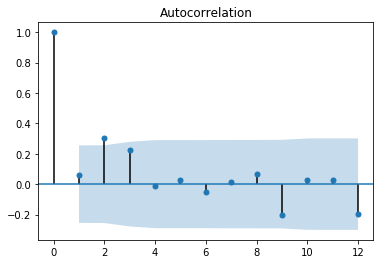

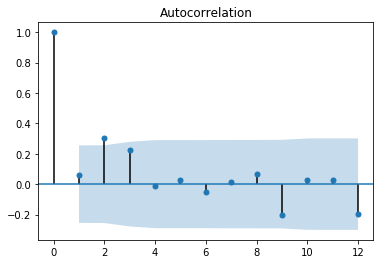

In [90]:
# A:
plot_acf(residuals, lags = 12)

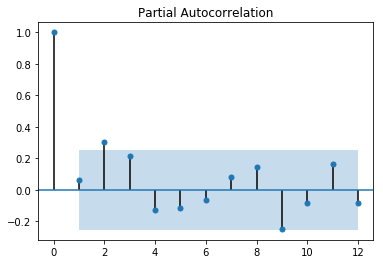

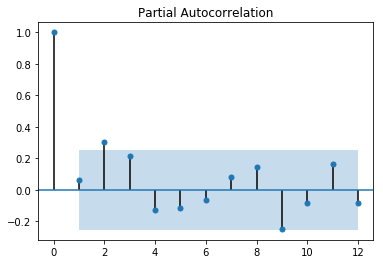

In [93]:
plot_pacf(residuals, lags = 12)

**Increase the order of the SARIMAX model.**

How do the results change?

In [95]:
# A:
model = sm.tsa.statespace.SARIMAX(df.values, order=(0,1,2),
                                  seasonal_order=(0,1,1,4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 4)   Log Likelihood                 -32.809
Date:                           Tue, 26 Jun 2018   AIC                             73.618
Time:                                   15:36:30   BIC                             82.254
Sample:                                        0   HQIC                            77.020
                                            - 64                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2307      0.157      1.471      0.141      -0.077       0.538
ma.L2          0.2497      0.115      2.171      0.030       0.024       0.475
ma.S.L4       -0.6987      0.149     -4.695      0.000      -0.990      -0.407
sigma2         0.1694      0.028      5.944      0.000       0.114       0.225
===================================================================================
Ljung-Box (Q):                       33.80   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.74   Prob(JB):                         0.46
Heteroskedasticity (H):               0.69   Skew:                            -0.10
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<a id="forecast-using-the-sarimax-model"></a>
### Forecast Using the SARIMAX Model

Statsmodels result objects from SARIMAX have a `.forecast()` function that can use the state-space model to predict out to future time points.

Forecast 12 additional time points and plot them.

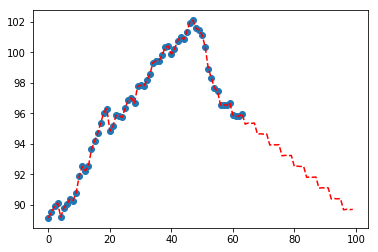

In [96]:
# Forecasting:
res = model.fit()
preds = res.forecast(36)
fcast = np.concatenate((df.values, preds), axis=0)

plt.figure();
plt.plot(df.values, 'o' , fcast, 'r--');

<a id='additional-resources'></a>
## Additional Resources
---

+ A Soft Introduction to [Akaike Information Criteria](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)
+ A [Video Introduction](https://www.youtube.com/watch?v=YkD7ydzp9_E) to AIC
+ [Wikipedia's Entry on AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)
+ A Seasonal ARIMA [Code-Along](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) From Statsmodels
+ An excellent [Blog Code-Along](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) to Seasonal ARIMA + [iPython Notebook](https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb)
+ Duke's Breakdown of [ACF and PACF](http://people.duke.edu/~rnau/411arim3.htm)
+ Duke's Breakdown of Available [Stationarity Transformations](http://people.duke.edu/~rnau/whatuse.htm)
+ A 35-Minute [Video Econometric](https://www.youtube.com/watch?v=Y2khrpVo6qI) Breakdown of ARIMA
+ [Wikipedia's Entry on Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
+ Stats Exchange's Breakdown of [Augmented Dickey-Fuller](http://stats.stackexchange.com/questions/44647/which-dickey-fuller-test-should-i-apply-to-a-time-series-with-an-underlying-mode)
+ Compliments of Jonathan: A Walk-Through of Selecting PDQ from [Duke](http://people.duke.edu/~rnau/411arim.htm)
+ Compliments of Jonathan, Pt. 2: A Big Data Analytics With ARIMA [Case Study](http://sda-pakdd2014.weebly.com/uploads/2/4/0/8/24088081/7w12.pdf)
+ Bonus: Check Out [Granger Causality Tests](https://en.wikipedia.org/wiki/Granger_causality)
